In [2]:
import sys
sys.executable

'/usr/bin/python3.6'

In [3]:
ls ../dockerdrive/

 02-acoustic-model.py*
 DASHclean/
 DASHnoisy/
'Data Loader.ipynb'
'Data Loader - Phoneme Level.ipynb'
'Data Loader - PLC feature.ipynb'
'Data Loader - With Dictionary.ipynb'
 dataset/
 datasets/
 dset.txt
'EDA on filters on data.ipynb'
 exp1_czt.h5
 exp1_stft.h5
'Experiment 1 - CZT - stabilized-Copy2.ipynb'
'Experiment 1 - CZT - stabilized.ipynb'
'Experiment 1 - CZT - stabilized with coeffs.ipynb'
'Experiment 1 - MFCC.ipynb'
'Experiment 1 - PLC - nan.ipynb'
'Experiment 1 - STFT.ipynb'
 Healthcheck.ipynb
'Knet installer and tester.ipynb'
 Krzysztok.ipynb
 lib/
 lstm.masking.harder.h5
 LSTM_Masking.ipynb
 models/
 NoisyTest2.tgz
'Simple Basic Acoustic Model for Larger Corpus - comparison.ipynb'
'Simple Basic Acoustic Model for Larger Corpus-Copy1.ipynb'
'Simple Basic Acoustic Model for Larger Corpus-Copy2.ipynb'
'Simple Basic Acoustic Model for Larger Corpus - CZT-Copy1.ipynb'
'Simple Basic Acoustic Model for Larger Corpus - CZT-Copy2.ipynb'
'Simple Basic Acoustic Model for Larger Corpu

In [1]:
import librosa
import numpy as np
import os
import scipy.io.wavfile as sio

cleans = os.listdir("../8chclean")[:300]
noisy = os.listdir("../8ch")[:300]
cleans = [sio.read("../8chclean/" + x)[1].astype(np.float32) / 2**15 for x in cleans]
noisy = [sio.read("../8ch/" + x)[1].astype(np.float32) / 2**15 for x in noisy]
cleans = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for x in cleans for i in range(8)]
noisy = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for record in noisy for x in record.T]

In [2]:
maxlen = max([x.shape[0] for x in cleans])
cleans = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in cleans])
noisy = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in noisy])

In [3]:
masks = np.clip(cleans / (noisy + 2e-12), 0, 1)

In [4]:
import keras
from keras.layers import Dense, LSTM, Conv2D, LeakyReLU, BatchNormalization, Flatten, TimeDistributed, Lambda
from keras.regularizers import L1L2

model = keras.models.Sequential() 
model.add(LSTM(512, input_shape=(None, 257), return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model.add(Dense(257)) 
model.add(LeakyReLU(0.01)) 
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6))) 
model.add(Dense(257)) 
model.add(LeakyReLU(0.01)) 
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6), recurrent_regularizer=L1L2(l1=1e-6)))  
model.add(Dense(257)) 
model.add(LeakyReLU(0.01)) 
model.compile(keras.optimizers.Adam(1e-3, clipnorm=1.), 'mse') 
model.summary()    

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 512)         1576960   
_________________________________________________________________
dense_1 (Dense)              (None, None, 257)         131841    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, 257)         0         
_________________________________________________________________


In [7]:
# TODO: train on proper noisy ones
model.fit(noisy[:2200], masks[:2200], epochs=50, batch_size=32, validation_data=[noisy[2200:], masks[2200:]])

Train on 2200 samples, validate on 200 samples
Epoch 1/50
2200/2200 [==============================] - 516s 235ms/step - loss: 0.1495 - val_loss: 0.1173
Epoch 2/50
2200/2200 [==============================] - 518s 235ms/step - loss: 0.0974 - val_loss: 0.0893
Epoch 3/50
2200/2200 [==============================] - 517s 235ms/step - loss: 0.0808 - val_loss: 0.0793
Epoch 4/50
2200/2200 [==============================] - 513s 233ms/step - loss: 0.0737 - val_loss: 0.0708
Epoch 5/50
2200/2200 [==============================] - 517s 235ms/step - loss: 0.0671 - val_loss: 0.0666
Epoch 6/50
2200/2200 [==============================] - 517s 235ms/step - loss: 0.0652 - val_loss: 0.0642
Epoch 7/50
2200/2200 [==============================] - 517s 235ms/step - loss: 0.0613 - val_loss: 0.0616
Epoch 8/50
2200/2200 [==============================] - 516s 234ms/step - loss: 0.0592 - val_loss: 0.0604
Epoch 9/50
2200/2200 [==============================] - 517s 235ms/step - loss: 0.0583 - val_loss: 0.0587

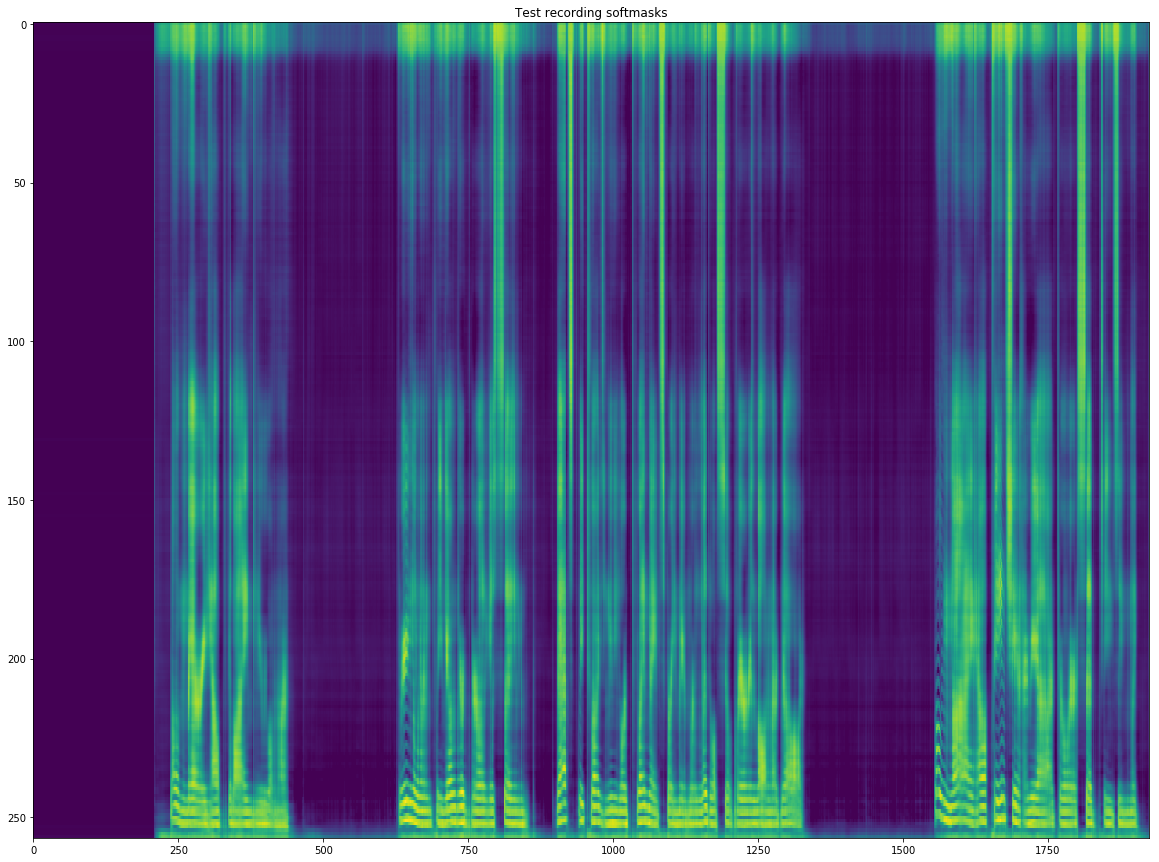

In [20]:
import matplotlib.pyplot as plt
a = model.predict(noisy[2320:2321])[0]
plt.figure(figsize=(20,15))
plt.imshow(np.flip(a.T[:, 230:], 0), aspect='auto')
plt.title("Test recording softmasks")
plt.show()

In [ ]:
# Fitting more than 50 epochs.... additional ones
model.fit(noisy[:500], masks[:500], epochs=50, batch_size=32, validation_data=[noisy[500:], masks[500:]])

Train on 500 samples, validate on 40 samples
Epoch 1/50
500/500 [==============================] - 117s 233ms/step - loss: 0.0476 - val_loss: 0.0604
Epoch 2/50
500/500 [==============================] - 116s 231ms/step - loss: 0.0475 - val_loss: 0.0605
Epoch 3/50
500/500 [==============================] - 116s 232ms/step - loss: 0.0475 - val_loss: 0.0603
Epoch 5/50
500/500 [==============================] - 116s 232ms/step - loss: 0.0471 - val_loss: 0.0603
Epoch 6/50
500/500 [==============================] - 115s 231ms/step - loss: 0.0469 - val_loss: 0.0600
Epoch 7/50
500/500 [==============================] - 115s 230ms/step - loss: 0.0465 - val_loss: 0.0603
Epoch 8/50
500/500 [==============================] - 116s 232ms/step - loss: 0.0465 - val_loss: 0.0604
Epoch 9/50
500/500 [==============================] - 116s 232ms/step - loss: 0.0463 - val_loss: 0.0602
Epoch 10/50
500/500 [==============================] - 116s 232ms/step - loss: 0.0464 - val_loss: 0.0608
Epoch 11/50
500/50

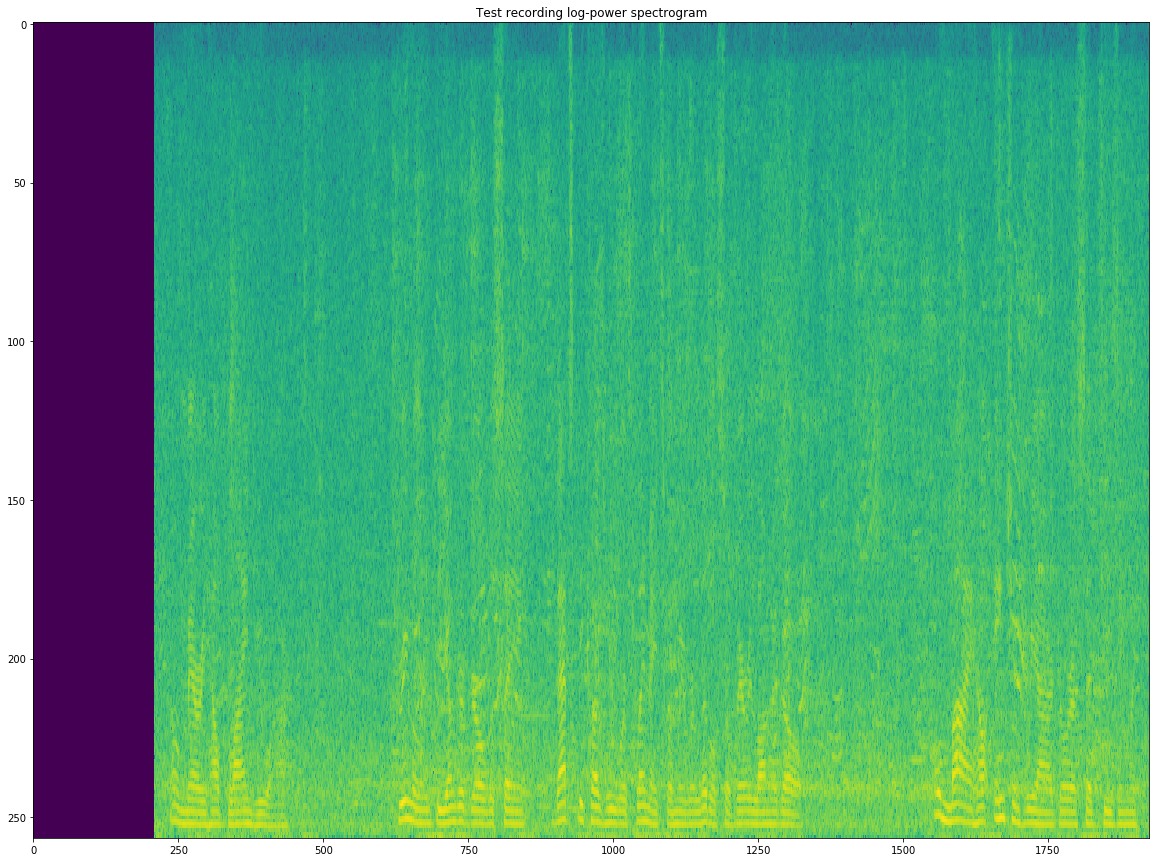

In [15]:
plt.figure(figsize=(20,15))
plt.imshow(np.flip(np.log(noisy[2320:2321][0].T[:, 230:]**2 + 2e-12), 0), aspect='auto')
plt.title("Test recording log-power spectrogram")
plt.show()

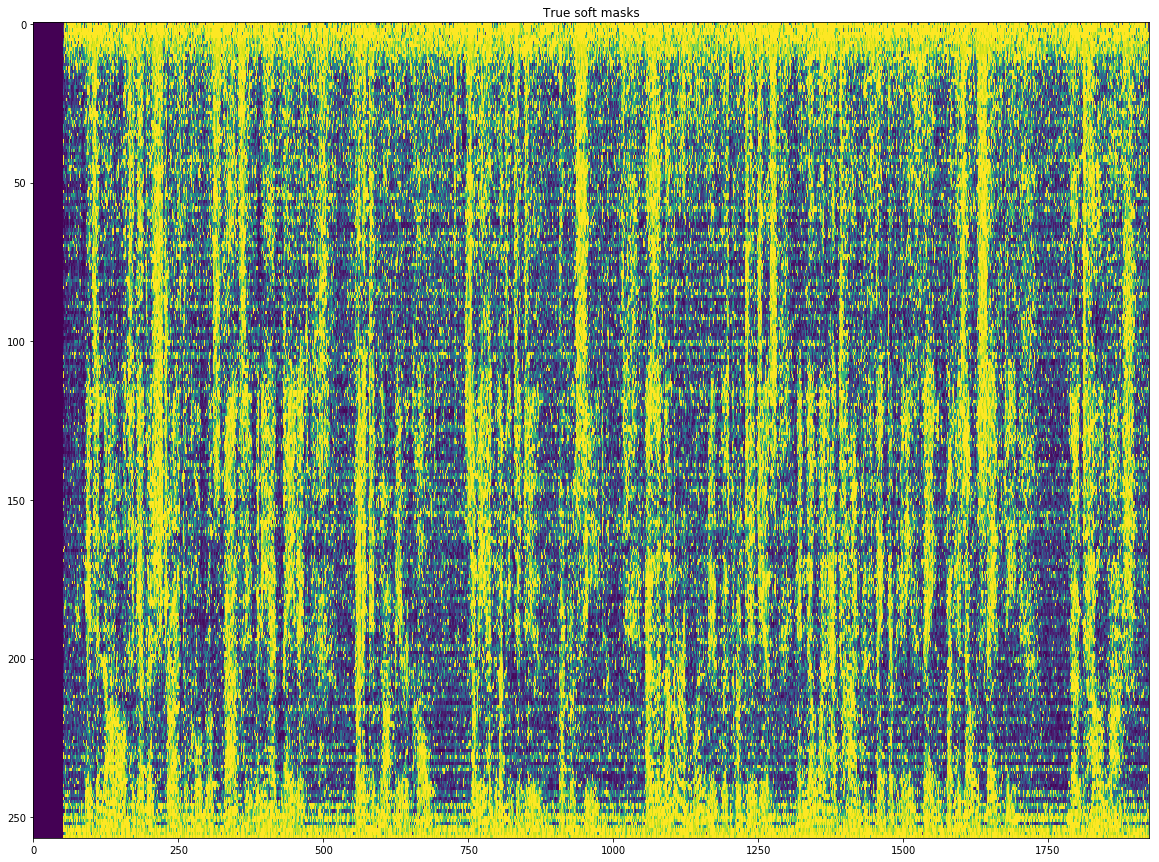

In [18]:
plt.figure(figsize=(20,15))
plt.imshow(np.flip(masks[2220:2221][0].T[:, 230:], 0), aspect='auto')
plt.title("True soft masks")
plt.show()

In [108]:
r = os.listdir("DASHnoisy")[520 // 6 + int(bool(520 % 6)) - 1]
d = sio.read("DASHnoisy/" + r)[1]
spec = librosa.stft(d.astype(np.float32).T[4] / 2**15, n_fft=512, hop_length=128).T
spec2 = a[-1934:]* spec
### mask = abs(clean) / abs(noise)
### abs(clean) = mask * abs(noise)
sound = librosa.istft(spec2.T, hop_length=128)

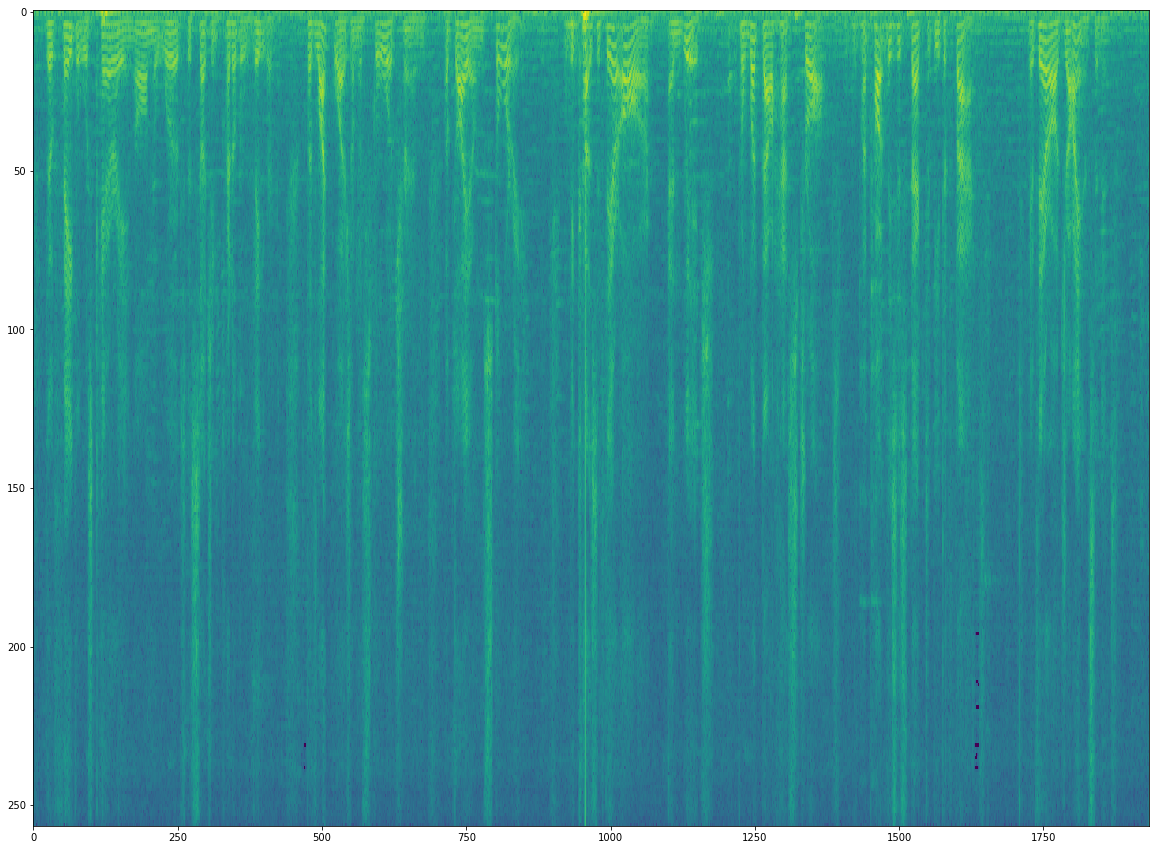

In [109]:
plt.figure(figsize=(20,15))
plt.imshow(np.abs(spec2.T)**0.1, aspect='auto')

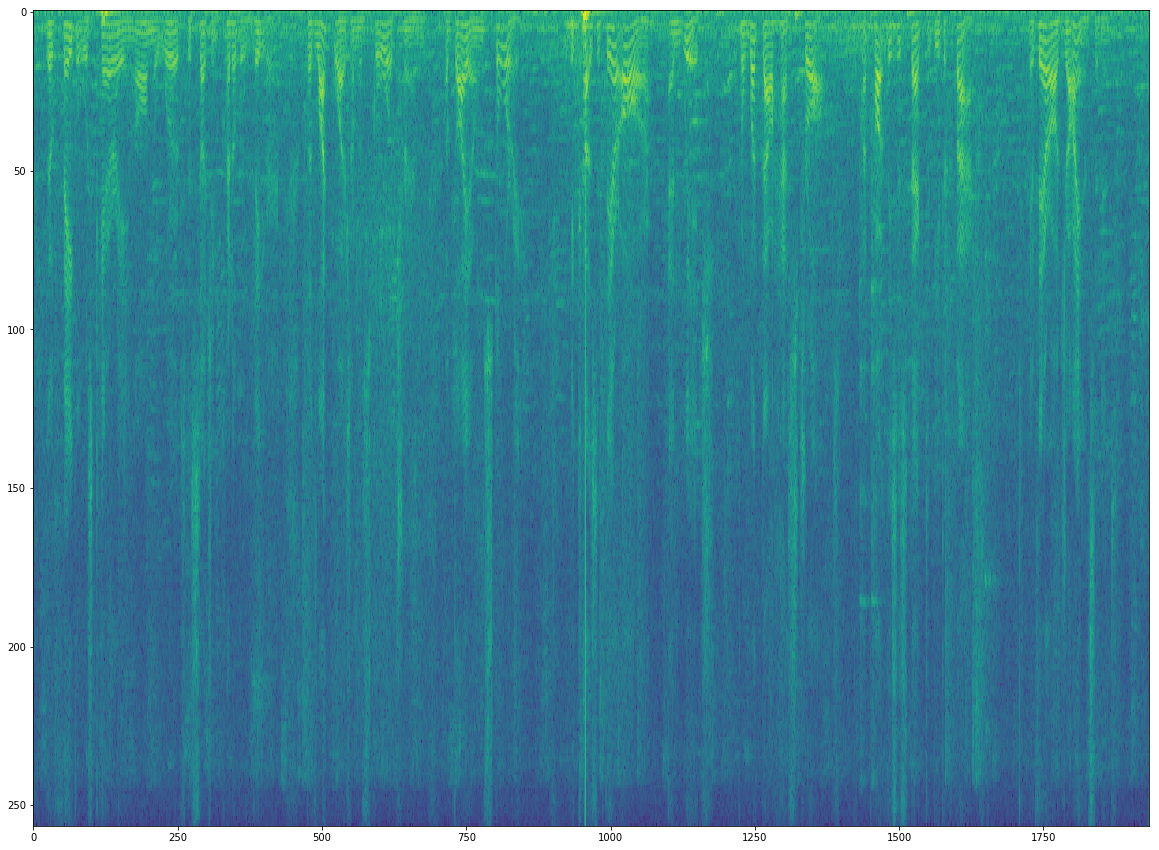

In [110]:
plt.figure(figsize=(20,15))
plt.imshow(np.abs(spec.T)**0.1, aspect='auto')

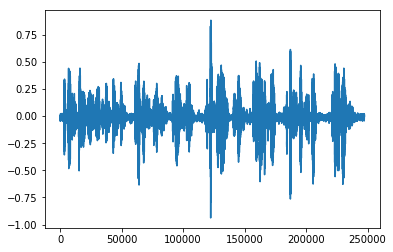

In [111]:
plt.plot(sound)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))

In [113]:
display(Audio(d.T[4], rate=16000))

In [21]:
model.save("3layer-mask.h5") # model on GoogleDrive

In [32]:
a = sio.read("../8ch/277.wav")[1][:, 0].astype(np.float32)
a = librosa.stft(a, n_fft=512).T

mod = np.abs(a)
phs = np.angle(a)

A = model.predict(a.reshape(1, -1, 257))[0]
mod2 = (a * A) * np.exp(1j * phs)
sound = librosa.istft(mod2.T)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))
sio.write("/home/zantyr/filtered-277.wav", 16000, sound)

In [30]:
a.shape

(257, 2016)

In [33]:
a = sio.read("../8ch/290.wav")[1][:, 0].astype(np.float32)
a = librosa.stft(a, n_fft=512).T

mod = np.abs(a)
phs = np.angle(a)

A = model.predict(a.reshape(1, -1, 257))[0]
mod2 = (a * A) * np.exp(1j * phs)
sound = librosa.istft(mod2.T)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))
sio.write("/home/zantyr/filtered-290.wav", 16000, sound)